In [14]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import random
from collections import Counter
from keras import regularizers
from keras.models import Model
from keras.layers import Input, Embedding, concatenate, Flatten, GlobalAveragePooling2D
from keras.layers.core import Dense, Reshape, Lambda, Dropout
from keras.utils import to_categorical
from keras.applications.vgg19 import VGG19
#from keras.applications import MobileNet
from keras.preprocessing.image import load_img, save_img, img_to_array
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.initializers import Constant
from tensorflow import set_random_seed
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from scipy.misc import imresize
from DataGenerator_with_embedded_imgs import DataGenerator
import math
import pickle
from sklearn.metrics import classification_report

BASE_DIR = "../.."
DATA_DIR = "data"
IMG_DIR = "images"
IMG_EMBEDDED_DIR = "VGG19_FC2_embed"
DATA_FILE = "balanced_data.csv"

SPLIT_RATIO = [0.7, 0.15, 0.15] # training : validation : test

data_path = os.path.join(BASE_DIR, DATA_DIR, DATA_FILE)
img_path = os.path.join(BASE_DIR, IMG_DIR)
imgEmbd_dir = os.path.join(BASE_DIR, 'src', IMG_EMBEDDED_DIR)

In [2]:
# 'media_shortcode' and 'label' are the only columns that matter in image classification
data = pd.read_csv(data_path).loc[:, ['media_shortcode', 'label']]
data.reset_index(drop=False, inplace=True)
# build a imgID-img_shortCode dictionary, since data will be stored in a numpy array
imgID_shortCode = {idx : code for idx, code in zip(data.index, data.media_shortcode)}

## Example of a media image

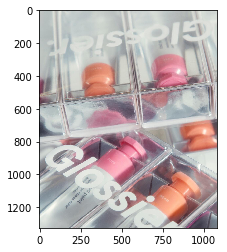

In [3]:
image = mpimg.imread(img_path + '/'+ 'Bc0lx8sBcF3'+'.jpg')
plt.imshow(image)

# Split all data into training, validation and test sets

## Multi-hot encoding for multi-labels

In [4]:
def multi_hot_encoding(labels):
    """ multi-hot encoding for the labels of each meida post 
        Args:
            labels: list, dimension of rows may not be same
        Return:
            num_of_classes: int, total number of classes
            res: array, num_of_examples x num_of_classes, multi-hot encoded array
    """
    # number of classes
    num_examples, min_idx, max_idx = len(labels), float('inf'), -float('inf')
    for row in labels:
        for col in row:
            if col < min_idx:
                min_idx = col
            if col > max_idx:
                max_idx = col
    num_of_classes = max_idx - min_idx + 1
    
    res = np.zeros((num_examples, max_idx-min_idx+1), dtype = int)
    for row in range(len(labels)):
        lbls = labels[row]
        for col in lbls:
            res[row, col] = 1
    return num_of_classes, res
    

In [5]:
represented_data = np.array(data.index).reshape(-1,1)
labels_str = data.label.values
labels = []
for str_label in labels_str:
    label = [int(i) for i in str_label[1:-1].split(',')]
    labels.append(label)

num_of_classes, encoded_labels_arr = multi_hot_encoding(labels)
represented_data = np.concatenate((represented_data, encoded_labels_arr), axis = 1)

In [6]:
print(len(represented_data))

101914


In [7]:
def split_data(orig_data, split_ratio, num_of_classes):
    """ Split dataframe into train, validation and test datasets."""
    np.random.seed(42)
    np.random.shuffle(orig_data)
    data_after_split, tmp, length = {}, {}, len(orig_data)
    
    tmp['train'], tmp['val'], tmp['test'] = np.split(
        orig_data, [int(split_ratio[0] * length), int(1 - split_ratio[2] * length)], axis=0)
    
    for sett in ['train', 'val', 'test']:
        X = tmp[sett][:, :-num_of_classes]
        Y = tmp[sett][:, -num_of_classes:]
        data_after_split['X' + '_' + sett] = X
        data_after_split['Y' + '_' + sett] = Y

    print(data_after_split['X_train'].shape, data_after_split['Y_train'].shape,
          data_after_split['X_val'].shape, data_after_split['Y_val'].shape,
          data_after_split['X_test'].shape, data_after_split['Y_test'].shape)
    return data_after_split

In [8]:
print(represented_data.shape)
data_after_split = split_data(represented_data, SPLIT_RATIO, num_of_classes)

(101914, 41)
(71339, 1) (71339, 40) (15289, 1) (15289, 40) (15286, 1) (15286, 40)


# Train CNN

In [9]:
# To ensure reproducible results
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

#image_in = Input(shape=(,244,244,3))
# Input image is fed into VGG19
# Take the output of a intermediate layer
# https://towardsdatascience.com/https-medium-com-manishchablani-useful-keras-features-4bac0724734c
# Freeze every layer in VGG. Note that each layer has a "trainable" parameter

"""
# Transfer learning based on VGG19, output from 'fc1' layer
# Embeddings stored at ../VGG19_embeddImgs
# Add fully connected layers
# Try convolutional layers if calculation is slow
"""
# Embedded image vector from VGG19
image_in = Input(shape=(4096,))

# Add fully connected layers
regularizer_param = 0.0001

x=Dense(1024, activation='relu',
       kernel_regularizer=regularizers.l2(regularizer_param))(image_in)
x=Dense(512, activation='relu',
       kernel_regularizer=regularizers.l2(regularizer_param))(x)
x=Dense(128, activation='relu',
       kernel_regularizer=regularizers.l2(regularizer_param))(x)

output = Dense(num_of_classes, activation='sigmoid',
              kernel_regularizer=regularizers.l2(regularizer_param))(x) #final layer with softmax activation

model=Model(inputs=image_in,outputs=output)

def precision(y_true, y_pred):
    #Precision metric.
    y_pred = K.cast(K.greater(y_pred,0.5),dtype=float)
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(y_pred))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    #Recall metric.
    y_pred = K.cast(K.greater(y_pred,0.5),dtype=float)
    true_positives = K.sum(K.round(y_true * y_pred))
    actural_positives = K.sum(K.round(y_true))
    recall = true_positives / (actural_positives + K.epsilon())
    return recall

def exact_match_ratio(y_true, y_pred):
    #pred = tf.equal(tf.round(y_logits), tf.round(y_true))
    predictions = tf.to_float(tf.greater_equal(y_pred, 0.5))
    pred_match = tf.equal(predictions, tf.round(y_true))
    exact_match = tf.reduce_min(tf.to_float(pred_match), axis=1)
    return tf.reduce_mean(exact_match)

model.compile(loss='binary_crossentropy', 
            optimizer='adam', metrics=[precision, recall, exact_match_ratio])


print(model.summary())

batch_size = 128
training_generator = DataGenerator(data_after_split['X_train'], data_after_split['Y_train'],
                                      imgID_shortCode, imgEmbd_dir, batch_size)

validation_generator = DataGenerator(data_after_split['X_val'], data_after_split['Y_val'],
                                      imgID_shortCode, imgEmbd_dir, batch_size)

# validation_steps: Total number of steps (batches of samples) to yield from validation_data generator 
# before stopping at the end of every epoch. It should typically be equal to the number of samples of 
# your validation dataset divided by the batch size.
history = model.fit_generator(generator=training_generator, validation_data = validation_generator,
                    steps_per_epoch = int(math.ceil(len(data_after_split['X_train']) / batch_size)),
                    validation_steps = int(math.ceil(len(data_after_split['X_val']) / batch_size)),
                    shuffle=True, epochs=20)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 40)                5160      
Total params: 4,790,952
Trainable params: 4,790,952
Non-trainable params: 0
_________________________________________________________________
None
Instruc

In [10]:
with open('CNN_history', 'wb') as fin:
        pickle.dump(history.history, fin)
model.save('CNN_model.h5')

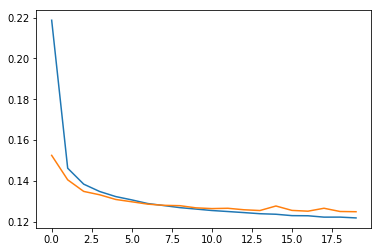

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [12]:
def get_precision(y_true, y_pred):
    #Precision metric.
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <0.5] = 0
    true_positives = np.sum(y_pred*y_true)
    predicted_positives = np.sum(y_pred)
    return true_positives / predicted_positives

def get_recall(y_true, y_pred):
    #Recall metric.
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <0.5] = 0
    true_positives = np.sum(y_pred*y_true)
    actural_positives = np.sum(y_true)
    return true_positives / actural_positives

def get_exact_match_ratio(y_true, y_pred):
    match = np.equal(y_pred, y_true)
    match = np.amin(match, axis=1)
    exact_match_ratio = np.mean(match)
    return exact_match_ratio

In [13]:
# test set data generator, note tht batch size = number of samples
test_generator = DataGenerator(data_after_split['X_test'], data_after_split['Y_test'],
                                      imgID_shortCode, imgEmbd_dir, batch_size=len(data_after_split['X_test']))

y_pred = model.predict_generator(generator=test_generator)
y_true = data_after_split['Y_test']

precision, recall,  = get_precision(y_true, y_pred), get_recall(y_true, y_pred)
exact_math_ratio = get_exact_match_ratio(y_true, y_pred)

print("precision, recall and exact match ratio for test set are %.4f, %.4f and %.4f" \
      %(precision, recall, exact_math_ratio))

precision, recall and exact match ratio for test set are 0.7208, 0.1514 and 0.1514


In [16]:
classID_className = {0: 'color cosmetics:eye:eyebrow', 1: 'skincare:skincare:moisturizer', 2: 'color cosmetics:eye:eyeshadow', 3: 'color cosmetics:eye:mascara', 4: 'accessories:accessories:brush', 5: 'fragrance:fragrance:fragrance', 6: 'skincare:skincare:cleanser', 7: 'accessories:accessories:tool', 8: 'nail:nail:nail polish', 9: 'color cosmetics:eye:eye palette', 10: 'bath body:bath body:wash', 11: 'hair:style:styling products', 12: 'skincare:skincare:treatments', 13: 'color cosmetics:face:powder', 14: 'skincare:skincare:mask', 15: 'bath body:bath body:body lotion', 16: 'hair:cleanse:conditioner', 17: 'color cosmetics:cheek:cheek palette', 18: 'color cosmetics:lip:lipstick', 19: 'hair:treat:hair treatments', 20: 'color cosmetics:cheek:highlighter', 21: 'hair:cleanse:shampoo', 22: 'color cosmetics:face:setting spray', 23: 'color cosmetics:cheek:blush', 24: 'skincare:skincare:face suncare', 25: 'color cosmetics:eye:eyeliner', 26: 'color cosmetics:face:face palette', 27: 'color cosmetics:face:foundation', 28: 'color cosmetics:lip:lip balm', 29: 'skincare:skincare:face mist', 30: 'skincare:skincare:eyecare', 31: 'color cosmetics:eye:lash', 32: 'color cosmetics:lip:lip gloss', 33: 'color cosmetics:face:face primer', 34: 'color cosmetics:face:concealer', 35: 'color cosmetics:cheek:bronzer', 36: 'skincare:skincare:toner', 37: 'color cosmetics:lip:lip liner', 38: 'bath body:bath body:body suncare', 39: 'bath body:bath body:body glitter'}
target_names = [i.split(':')[2] for i in classID_className.values()]
print(classification_report(y_true, y_pred, target_names = target_names))

                  precision    recall  f1-score   support

         eyebrow       0.00      0.00      0.00       326
     moisturizer       0.62      0.01      0.02       405
       eyeshadow       0.00      0.00      0.00       311
         mascara       0.63      0.07      0.13       613
           brush       0.87      0.26      0.40       498
       fragrance       0.81      0.16      0.27       480
        cleanser       0.00      0.00      0.00       662
            tool       0.81      0.41      0.55       953
     nail polish       0.92      0.47      0.63       506
     eye palette       0.61      0.06      0.11       880
            wash       0.71      0.34      0.46       534
styling products       0.65      0.16      0.25       771
      treatments       0.63      0.01      0.03       844
          powder       0.00      0.00      0.00       438
            mask       0.00      0.00      0.00       292
     body lotion       0.70      0.11      0.19       565
     conditio

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
